In [2]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES

In [3]:
def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]

def prepare_problem(PARAMETER_RANGES, dependent_param="Pc_des"):
    independent_params = {
        k: v for k, v in PARAMETER_RANGES.items()
        if k != dependent_param
    }
    # Add dummy variable to later compute dependent_param
    z_key = f"z_{dependent_param}"
    independent_params[z_key] = (0, 1)

    bounds = [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
    bounds = make_bounds_exclusive(bounds)

    problem = {
        "num_vars": len(independent_params),
        "names": list(independent_params.keys()),
        "bounds": bounds,
        "groups": list(independent_params.keys())  # optional but useful for group-based SA
    }
    return problem

problem = prepare_problem(PARAMETER_RANGES)

In [4]:
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
import random

def generate_samples(problem, N=2, num_levels=4, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    samples = morris.sample(problem, N=N, num_levels=num_levels)

    # Add a new column for the trajectory number
    trajectory_numbers = np.tile(np.arange(1, N + 1), (problem["num_vars"], 1)).flatten()

    return pd.DataFrame(samples, columns=problem["names"]), trajectory_numbers

def compute_dependent_param(df_samples, param_name="Pc_des", Pext=101325):
    z_key = f"z_{param_name}"
    Pa_des = df_samples["Pa_des"]
    z = df_samples[z_key]

    low = np.maximum(Pext, Pa_des - 0.5e5)
    high = np.maximum(Pext, Pa_des - 0.1e5)

    df_samples[param_name] = low + z * (high - low)
    df_samples = df_samples.drop(columns=z_key)
    return df_samples, low, high

df_samples, trajectory_numbers = generate_samples(problem, N=10, num_levels=4)
df_samples, low, high = compute_dependent_param(df_samples)
print(df_samples.shape)

df_samples['e'] = np.round(df_samples['e'])


(200, 19)


In [5]:
def is_sample_in_bounds(sample, bounds_dict):
    """
    Check if a sample is within the specified parameter bounds.

    Args:
        sample (dict): A dictionary of parameter values.
        bounds_dict (dict): A dictionary with parameter names as keys and tuples or lists as bounds.

    Returns:
        bool: True if all parameters are within bounds, False otherwise.
        dict: A dictionary of out-of-bound parameters with their values and bounds.
    """
    out_of_bounds = {}

    for key, bounds in bounds_dict.items():
        if key not in sample:
            continue  # skip if not part of the sample

        value = sample[key]

        if bounds is None:
            continue  # no bounds specified

        if isinstance(bounds, tuple):
            lower, upper = bounds
            if not (lower <= value <= upper):
                out_of_bounds[key] = {"value": value, "bounds": bounds}

        elif isinstance(bounds, list):
            if value not in bounds:
                out_of_bounds[key] = {"value": value, "allowed": bounds}

    return len(out_of_bounds) == 0, out_of_bounds

for sample in df_samples.to_dict(orient='records'):
    res = is_sample_in_bounds(sample, bounds_dict=PARAMETER_RANGES)
    if res[0] == False:
        print(res[1])

In [6]:
#results = get_polarisation_curve_samples(df_samples.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path='../data/raw/morris_sample_results_N10_lev4.pkl')
results = pd.read_pickle('../data/raw/morris_sample_results_N10_lev4_corrected.pkl')

In [7]:
def replace_z_with_actual_param(problem, low, high, param_name="Pc_des"):
    z_key = f"z_{param_name}"
    idx = problem["names"].index(z_key)
    problem["names"][idx] = param_name
    problem["bounds"][idx] = (low.min(), high.max())
    problem["groups"][idx] = param_name
    return problem

problem = replace_z_with_actual_param(problem, low, high)

In [8]:
import skfda
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA

def perform_functional_PCA(results, output_key='Ucell', n_components = 3, cumulative_var = 0.95):

    Y_all = np.stack(results[output_key].values)
    n_outputs = Y_all.shape[1]
    
    fd = skfda.FDataGrid(data_matrix=Y_all, grid_points=range(n_outputs))
    
    # Initialize FPCA
    fpca = FPCA(n_components=n_components) 
    fpca.fit(fd)

    # Transform the data into FPCA scores (components' coefficients)
    Y_fpca_scores = fpca.transform(fd)

    # Explained variance by FPCA components
    explained_variance_ratio = np.cumsum(fpca.explained_variance_ratio_)
    
    # Select how many components to keep (explaining cumulative_var% of the variance)
    n_components_to_keep = np.argmax(explained_variance_ratio >= cumulative_var) + 1

    return Y_fpca_scores, explained_variance_ratio, n_components_to_keep

Y_fpca_scores, explained_var, n_comp_keep = perform_functional_PCA(results, output_key='Ucell')

C:\Users\Camila Bermudez\AppData\Local\Temp\ipykernel_28296\598545817.py:2: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [20]:
Y_all = np.stack(results['Ucell'].values)
n_outputs = Y_all.shape[1]

fd = skfda.FDataGrid(data_matrix=Y_all, grid_points=range(n_outputs))

# Initialize FPCA
fpca = FPCA(n_components=3) 
fpca.fit(fd)

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=3)

In [23]:
Y_all

array([[ 3.475704  ,  3.30453334,  3.17947845, ...,  0.68222813,
         0.57412126,  0.4638197 ],
       [ 2.47051761,  2.31671612,  2.19266692, ..., -0.88230335,
        -1.02977499, -1.1813572 ],
       [ 1.96747469,  1.83419514,  1.71903727, ..., -1.65393436,
        -1.82731153, -2.00673537],
       ...,
       [ 2.53708515,  2.40307824,  2.28388477, ..., -1.08538298,
        -1.26478074, -1.45170965],
       [ 2.98308138,  2.83884321,  2.7163872 , ..., -0.31669299,
        -0.46612374, -0.6204752 ],
       [ 2.98308138,  2.83884321,  2.7163872 , ..., -0.31669299,
        -0.46612374, -0.6204752 ]])

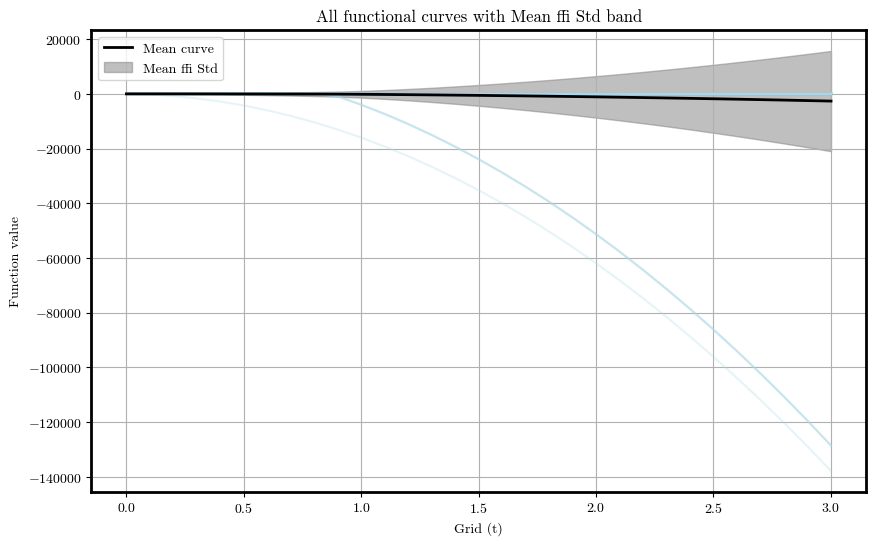

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assume Y_curves is (n_samples, n_time_points)
n_samples, n_time_points = Y_all.shape
grid_points = results['ifc'][0]

# Calculate mean and std across the samples
mean_curve = np.mean(Y_all, axis=0)
std_curve = np.std(Y_all, axis=0)

plt.figure(figsize=(10, 6))

# Plot all curves
for i in range(n_samples):
    plt.plot(grid_points, Y_all[i, :], alpha=0.3, color='lightblue')

# Plot mean curve
plt.plot(grid_points, mean_curve, color='black', linewidth=2, label='Mean curve')

# Plot mean ± std as a shaded area
plt.fill_between(
    grid_points,
    mean_curve - std_curve,
    mean_curve + std_curve,
    color='gray',
    alpha=0.5,
    label='Mean ± Std'
)

plt.title('All functional curves with Mean ± Std band')
plt.xlabel('Grid (t)')
plt.ylabel('Function value')
plt.legend()
plt.grid(True)
plt.show()


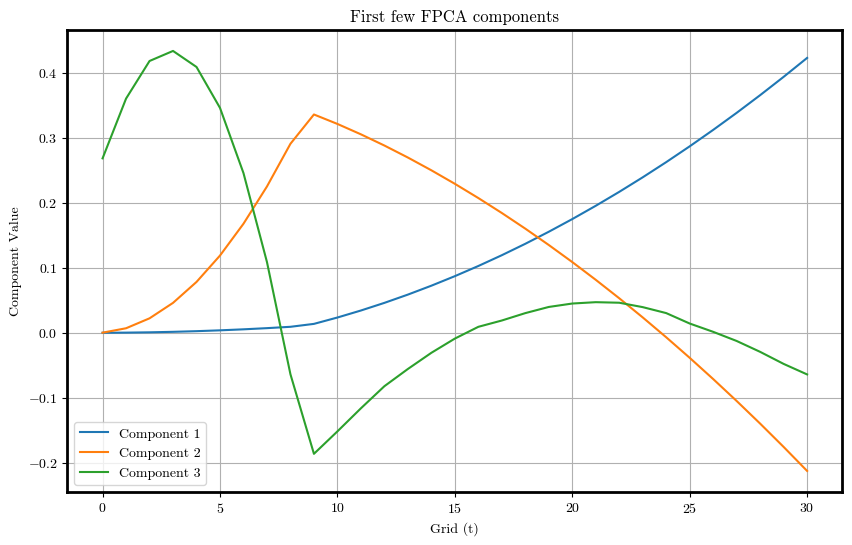

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# fpca.components_ contains the principal components (as FDataBasis objects usually)
# but in case of FDataGrid, it’s an FDataGrid too.

# Plot the first few principal components
n_components_to_plot = 3  # or however many you computed
grid_points = range(31)  # same as your domain

plt.figure(figsize=(10, 6))

for i in range(n_components_to_plot):
    component = fpca.components_[i]
    plt.plot(grid_points, component.data_matrix[0, :, 0], label=f'Component {i+1}')

plt.title('First few FPCA components')
plt.xlabel('Grid (t)')
plt.ylabel('Component Value')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
def run_morris_analysis(df_samples, problem, Y_fpca_scores, num_levels=4,n_components =1):
    
    morris_all = []
    for i in range(n_components):
        analysis = morris_analyze.analyze(
            problem=problem,
            X=df_samples.to_numpy(),
            Y=Y_fpca_scores[:, i],
            conf_level=0.95,
            num_levels=num_levels,
            scaled = True,
            print_to_console=False
        )
        morris_all.append({
            'mu_star': analysis['mu_star'],
            'sigma': analysis['sigma'],
            'param': problem['names'],
            'output_index': i
        })
    return morris_all

morris_all = run_morris_analysis(df_samples, problem, Y_fpca_scores,n_components = n_comp_keep)


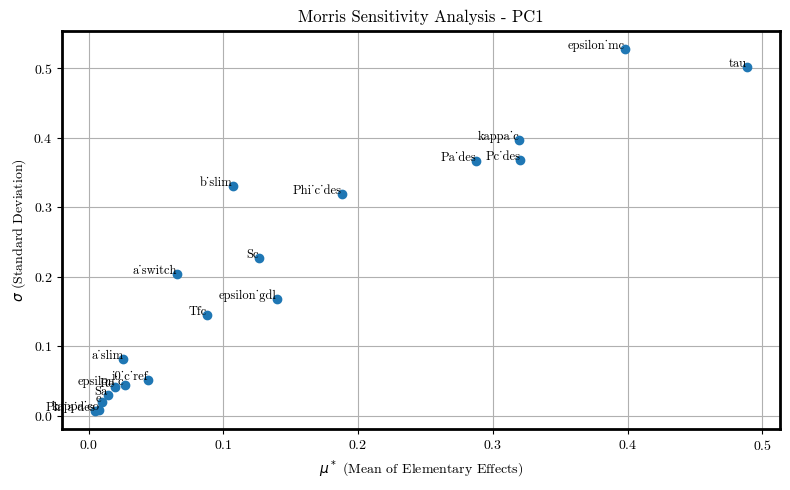

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_sensitivity_per_index(morris_all, figsize=(8, 5)):
    """
    Plots Morris sensitivity analysis results.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma', 'param', and 'output_index'
    - figsize: tuple, size of each plot
    """
    n_outputs = len(morris_all)

    for i in range(n_outputs):
        result = morris_all[i]
        mu_star = result['mu_star']
        sigma = result['sigma']
        param_names = result['param']

        plt.figure(figsize=figsize)
        plt.errorbar(mu_star, sigma, fmt='o', ecolor='gray', capsize=5)
        for j, param in enumerate(param_names):
            plt.text(mu_star[j], sigma[j], param, fontsize=9, ha='right')

        plt.title(f"Morris Sensitivity Analysis - PC{i+1}")
        plt.xlabel(r"$\mu^*$ (Mean of Elementary Effects)")
        plt.ylabel(r"$\sigma$ (Standard Deviation)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
plot_morris_sensitivity_per_index(morris_all)

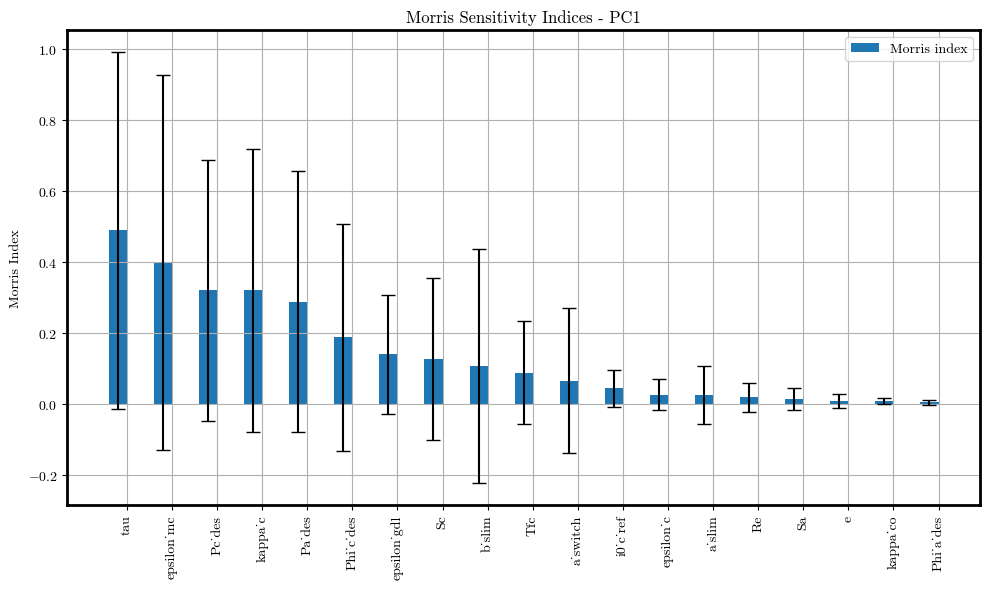

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_sensitivity_per_index(morris_all, figsize=(10, 6), sort_by='mu_star'):
    """
    Plot showing sensitivity (mu_star ± sigma) for each parameter.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star', 'sigma' (output of Morris analysis for each PC)
    - params: list of parameter names
    - n_cols: number of columns in subplot grid (default is 3)
    """
    n_outputs = len(morris_all)

    for i in range(n_outputs):
        result = morris_all[i]
        mu_star = result['mu_star']
        sigma = result['sigma']
        param_names = result['param']

        sorted_indices = np.argsort(mu_star)[::-1]  # Sort descending by mu_star
        params_sorted = [param_names[i] for i in sorted_indices]
        mu_star_sorted = mu_star[sorted_indices]
        sigma_conf_sorted = sigma[sorted_indices]
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(len(params_sorted))

        ax.bar(x - 0.2, mu_star_sorted, width=0.4, yerr=sigma_conf_sorted, label='Morris index', capsize=5)
        
        ax.set_ylabel('Morris Index')
        ax.set_title(f'Morris Sensitivity Indices - PC{i+1}')
        ax.set_xticks(x)
        ax.set_xticklabels(params_sorted, rotation=90)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

plot_morris_sensitivity_per_index(morris_all)

In [19]:
import numpy as np
import pandas as pd

def summarize_morris_results(morris_all, problem):
    """
    Summarizes Morris sensitivity analysis across multiple outputs.

    Parameters:
    - morris_all: list of dicts with keys 'mu_star' (list of float) and 'param' (list of str)
    - problem: dict containing 'names' (list of parameter names)

    Returns:
    - df_summary: DataFrame with mean and std of mu_star across outputs, sorted by importance
    """
    params = problem['names']
    mu_star_matrix = np.array([output['mu_star'] for output in morris_all])

    mu_star_mean = mu_star_matrix.mean(axis=0)
    mu_star_std = mu_star_matrix.std(axis=0)

    df_summary = pd.DataFrame({
        'Parameter': params,
        'Mu*_mean': mu_star_mean,
        'Mu*_std': mu_star_std
    })

    df_summary = df_summary.sort_values(by='Mu*_mean', ascending=False).reset_index(drop=True)
    return df_summary

summarize_morris_results(morris_all, problem)

,Parameter,Mu*_mean,Mu*_std
0,tau,0.488888,0.0
1,epsilon_mc,0.397934,0.0
2,Pc_des,0.320306,0.0
3,kappa_c,0.319699,0.0
4,Pa_des,0.287809,0.0
5,Phi_c_des,0.187799,0.0
6,epsilon_gdl,0.139803,0.0
7,Sc,0.126615,0.0
8,b_slim,0.107052,0.0
9,Tfc,0.088052,0.0
